# Scan SOL10111

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from impact import Impact, run_impact_with_distgen
from distgen import Generator

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

In [4]:
# Allows processes to work with macOS
from sys import platform
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")

# Initial setup from an archive

In [11]:
AFILE = 'c4ae3029fd7cb0e2f5bbbb54d8e5f589.h5'
G = Generator.from_archive(AFILE)
G['xy_dist:file'] = 'distgen_laser.txt'
G['n_particle']= 10000
G.run()
P0 = G.particles

In [24]:
I0 = Impact.from_archive(AFILE)
I0.initial_particles = P0
I0.numprocs = 1
I0.stop = 5
I0.verbose=False


In [68]:
I0 = Impact.from_archive(AFILE)

Px = I0.particles['L0AFEND'].copy()
Px.drift_to_z()
Px.z[:]=0
Px.t -= Px['mean_t']
Px.write('L0AFEND.h5')

# Initial setup from design

In [ ]:
G = Generator('$FACET2_LATTICE/distgen/models/f2e_inj/v0/distgen.yaml')
G['n_particle']= 10000
G.run()
P0 = G.particles
P0

In [ ]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.stop

In [ ]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.verbose=True

I0.stop = 4.2
I0.run()

In [ ]:
I0.plot('norm_emit_x')

In [ ]:
I0['SOL10111:solenoid_field_scale']

In [ ]:
I0['GUNF_phase:dtheta0_deg']

In [ ]:
## Basic set function

In [46]:
%%time
ZSTOP = 16
def set_attr(key, val):
    I = Impact.from_yaml('v0/ImpactT.yaml')
    I.initial_particles = P0
    I[key] = val
    I.stop = ZSTOP
    I.run()
    return I
    


CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 18.1 µs


# Scan `SOL10111:solenoid_field_scale`

# Parallel

In [47]:
from concurrent.futures import ProcessPoolExecutor

In [48]:
x0 = I0['SOL10111:solenoid_field_scale']
x0

0.19609741278068848

In [49]:
# Scan list
xlist = np.linspace(x0, 1.4*x0, 16)
xlist 

array([0.19609741, 0.20132668, 0.20655594, 0.21178521, 0.21701447,
       0.22224373, 0.227473  , 0.23270226, 0.23793153, 0.24316079,
       0.24839006, 0.25361932, 0.25884858, 0.26407785, 0.26930711,
       0.27453638])

In [50]:
%%time

# Have to define like this - lambdas do not work. 
def set1(val):
    return set_attr('SOL10111:solenoid_field_scale', val)

with ProcessPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(set1, xlist))

CPU times: user 261 ms, sys: 474 ms, total: 735 ms
Wall time: 17min 42s


0.19609741278068848 3055
0.20132667712150684 3055
0.2065559414623252 3055
0.21178520580314356 3055
0.2170144701439619 3055
0.22224373448478027 3055
0.22747299882559863 3055
0.232702263166417 3055
0.23793152750723534 3055
0.24316079184805373 3055
0.24839005618887205 3055
0.25361932052969044 3055
0.25884858487050877 3055
0.26407784921132715 3055
0.26930711355214554 3055
0.27453637789296387 3055


Text(0, 0.5, 'sigma_x (mm-mrad)')

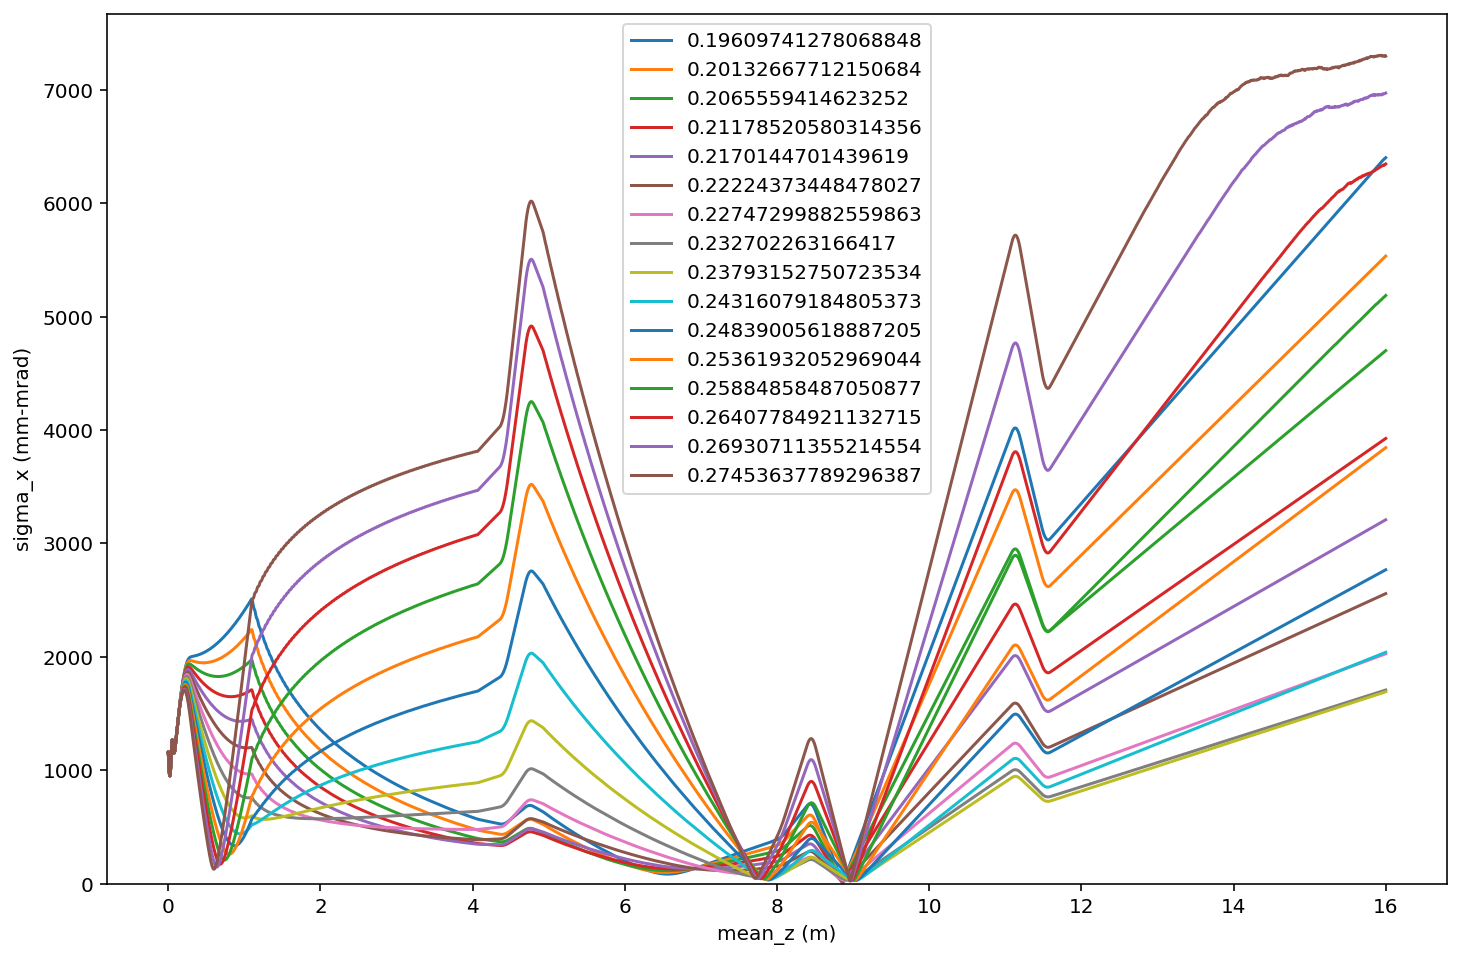

In [60]:
fig, ax = plt.subplots()

k1 = 'mean_z'
k2 = 'sigma_x'

f1 = 1
f2 = 1e6

for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)
    
ax.set_ylim(0, None)    
ax.legend()    
ax.set_xlabel(k1 + ' (m)')
ax.set_ylabel(k2 + ' (mm-mrad)')
    

In [52]:
for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)

0.19609741278068848 3055
0.20132667712150684 3055
0.2065559414623252 3055
0.21178520580314356 3055
0.2170144701439619 3055
0.22224373448478027 3055
0.22747299882559863 3055
0.232702263166417 3055
0.23793152750723534 3055
0.24316079184805373 3055
0.24839005618887205 3055
0.25361932052969044 3055
0.25884858487050877 3055
0.26407784921132715 3055
0.26930711355214554 3055
0.27453637789296387 3055


In [53]:
TWISS = [r.particles['L0AFEND'].twiss('xy') for r in results]


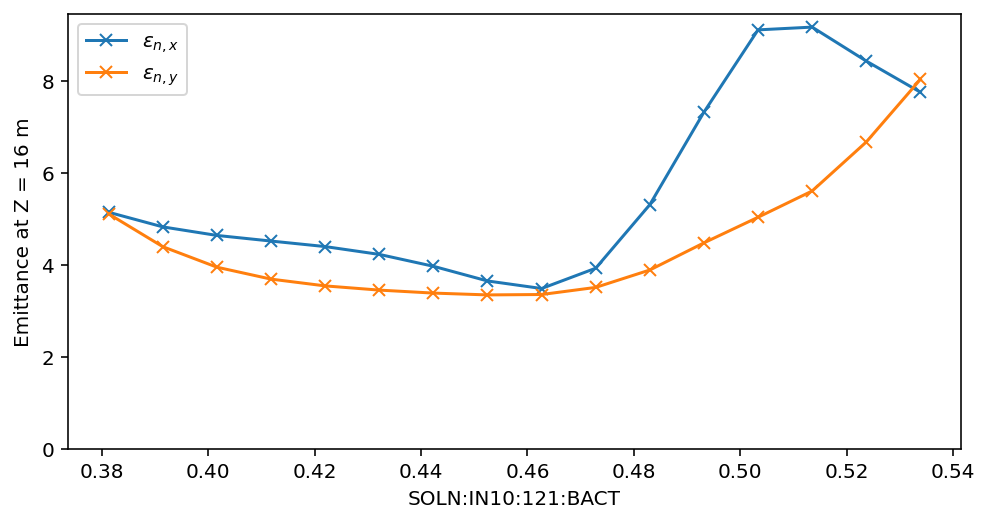

In [54]:

impact_factor = 0.51427242 # PV -> SOLN:IN10:121:BACT

emitx = np.array([I.stat('norm_emit_x')[-1] for I in results])
emity = np.array([I.stat('norm_emit_y')[-1] for I in results])
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xlist/impact_factor, emitx*1e6, marker='x', label=r'$\epsilon_{n, x}$')
ax.plot(xlist/impact_factor, emity*1e6, marker='x', label=r'$\epsilon_{n, y}$')
ax.set_ylabel(f'Emittance at Z = {ZSTOP} m')
ax.set_ylim(0,None)
ax.set_xlabel('SOLN:IN10:121:BACT')
plt.legend()

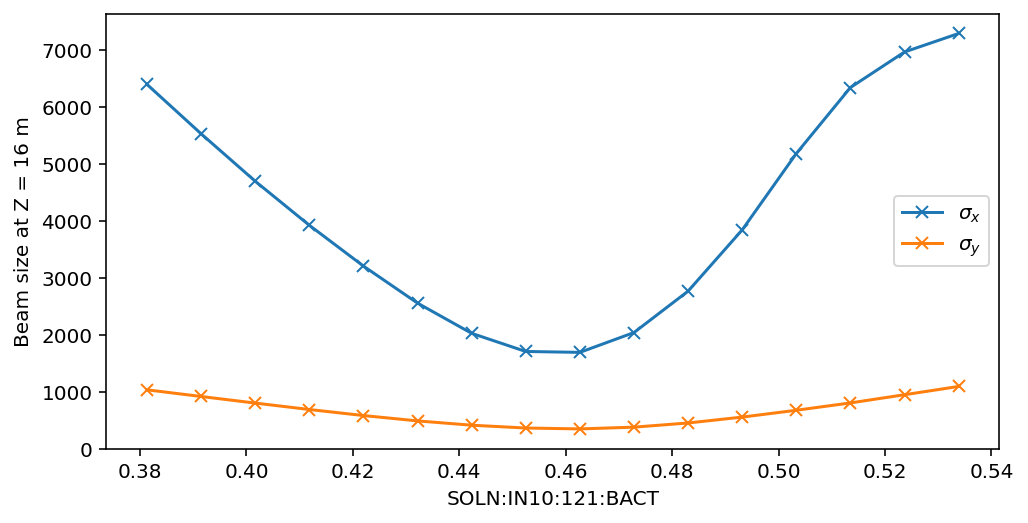

In [61]:
impact_factor = 0.51427242 # PV -> SOLN:IN10:121:BACT

x = np.array([I.stat('sigma_x')[-1] for I in results])
y = np.array([I.stat('sigma_y')[-1] for I in results])
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xlist/impact_factor,x*1e6, marker='x', label=r'$\sigma_x$')
ax.plot(xlist/impact_factor,y*1e6, marker='x', label=r'$\sigma_y$')
ax.set_ylabel(f'Beam size at Z = {ZSTOP} m')
ax.set_ylim(0,None)
ax.set_xlabel('SOLN:IN10:121:BACT')
plt.legend()

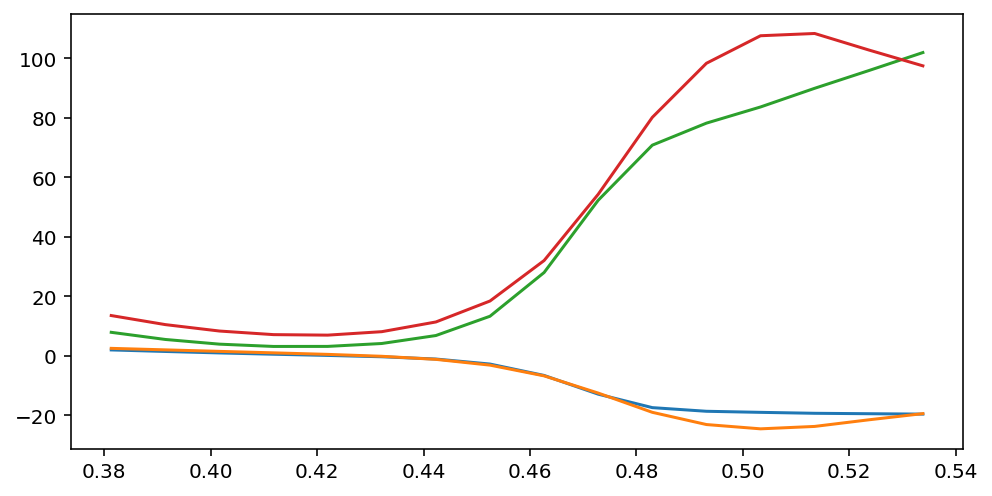

In [55]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xlist/impact_factor, [t['alpha_x'] for t in TWISS] )
ax.plot(xlist/impact_factor, [t['alpha_y'] for t in TWISS] )
ax.plot(xlist/impact_factor, [t['beta_x'] for t in TWISS] )
ax.plot(xlist/impact_factor, [t['beta_y'] for t in TWISS] )

# Scan GUNF phase

In [ ]:

ZSTOP = 0.2

#KEY = 'L0AF_phase:dtheta0_deg'
KEY = 'GUNF_phase:dtheta0_deg'

# Scan list
xlist = np.linspace(-40,0, 5)
xlist 

In [ ]:
%%time


# Have to define like this - lambdas do not work. 
def set1(val):
    return set_attr(KEY, val)

with ProcessPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(set1, xlist))

In [ ]:
fig, ax = plt.subplots()

k1 = 'mean_z'
k2 = 'mean_kinetic_energy'

f1 = 1
f2 = 1e6

for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)
    
#ax.set_ylim(0, 10)    
ax.legend()    
ax.set_xlabel(k1 + ' (m)')
ax.set_ylabel(k2 + ' (mm-mrad)')
    

In [ ]:
results[1].particles['final_particles'].plot('z', 'energy')

In [ ]:
results[1].particles['final_particles'].plot('Jy')

In [ ]:
vals = [I.particles['final_particles'].p.ptp() for I in results[1:]]

plt.plot(xlist[1:], vals, marker='x')

In [ ]:
I.particles['final_particles'].Jy